# Credit Card User Segmentation
## Outline
You work as a data scientist at a credit card company. A senior VP is leading an effort to reduce costs associated with signup incentives by offering credit cards with carefully targeted benefits that will attract new cardholders. As a first step, she would like you to examine cardholder data collected over the last 6 months in order to understand the various kinds of users who use the company’s products. She is especially interested in getting an idea of which benefits to associate with each new card offering.

## Key Findings

In [47]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

import sklearn
from sklearn.preprocessing import RobustScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

## Exploratory Data Analysis

In [3]:
# Import data
customers_df = pd.read_csv("cc_info.csv")
customers_df.head()

,CUST_ID,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
0,C10001,40.900749,0.818182,95.40,0.00,95.4,0.000000,0.166667,0.000000,0.083333,0.000000,0,2,1000.0,201.802084,139.509787,0.000000,12
1,C10002,3202.467416,0.909091,0.00,0.00,0.0,6442.945483,0.000000,0.000000,0.000000,0.250000,4,0,7000.0,4103.032597,1072.340217,0.222222,12
2,C10003,2495.148862,1.000000,773.17,773.17,0.0,0.000000,1.000000,1.000000,0.000000,0.000000,0,12,7500.0,622.066742,627.284787,0.000000,12
3,C10004,1666.670542,0.636364,1499.00,1499.00,0.0,205.788017,0.083333,0.083333,0.000000,0.083333,1,1,7500.0,0.000000,NaN,0.000000,12
4,C10005,817.714335,1.000000,16.00,16.00,0.0,0.000000,0.083333,0.083333,0.000000,0.000000,0,1,1200.0,678.334763,244.791237,0.000000,12


In [4]:
customers_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8950 entries, 0 to 8949
Data columns (total 18 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   CUST_ID                           8950 non-null   object 
 1   BALANCE                           8950 non-null   float64
 2   BALANCE_FREQUENCY                 8950 non-null   float64
 3   PURCHASES                         8950 non-null   float64
 4   ONEOFF_PURCHASES                  8950 non-null   float64
 5   INSTALLMENTS_PURCHASES            8950 non-null   float64
 6   CASH_ADVANCE                      8950 non-null   float64
 7   PURCHASES_FREQUENCY               8950 non-null   float64
 8   ONEOFF_PURCHASES_FREQUENCY        8950 non-null   float64
 9   PURCHASES_INSTALLMENTS_FREQUENCY  8950 non-null   float64
 10  CASH_ADVANCE_FREQUENCY            8950 non-null   float64
 11  CASH_ADVANCE_TRX                  8950 non-null   int64  
 12  PURCHA

In [23]:
# Check number of null in each column
customers_df.isnull().sum()

CUST_ID                               0
BALANCE                               0
BALANCE_FREQUENCY                     0
PURCHASES                             0
ONEOFF_PURCHASES                      0
INSTALLMENTS_PURCHASES                0
CASH_ADVANCE                          0
PURCHASES_FREQUENCY                   0
ONEOFF_PURCHASES_FREQUENCY            0
PURCHASES_INSTALLMENTS_FREQUENCY      0
CASH_ADVANCE_FREQUENCY                0
CASH_ADVANCE_TRX                      0
PURCHASES_TRX                         0
CREDIT_LIMIT                          1
PAYMENTS                              0
MINIMUM_PAYMENTS                    313
PRC_FULL_PAYMENT                      0
TENURE                                0
dtype: int64

The dataset is quite good. No high percentage of missing values, just "Minimum_payments" shows a 3.5% of missing values.

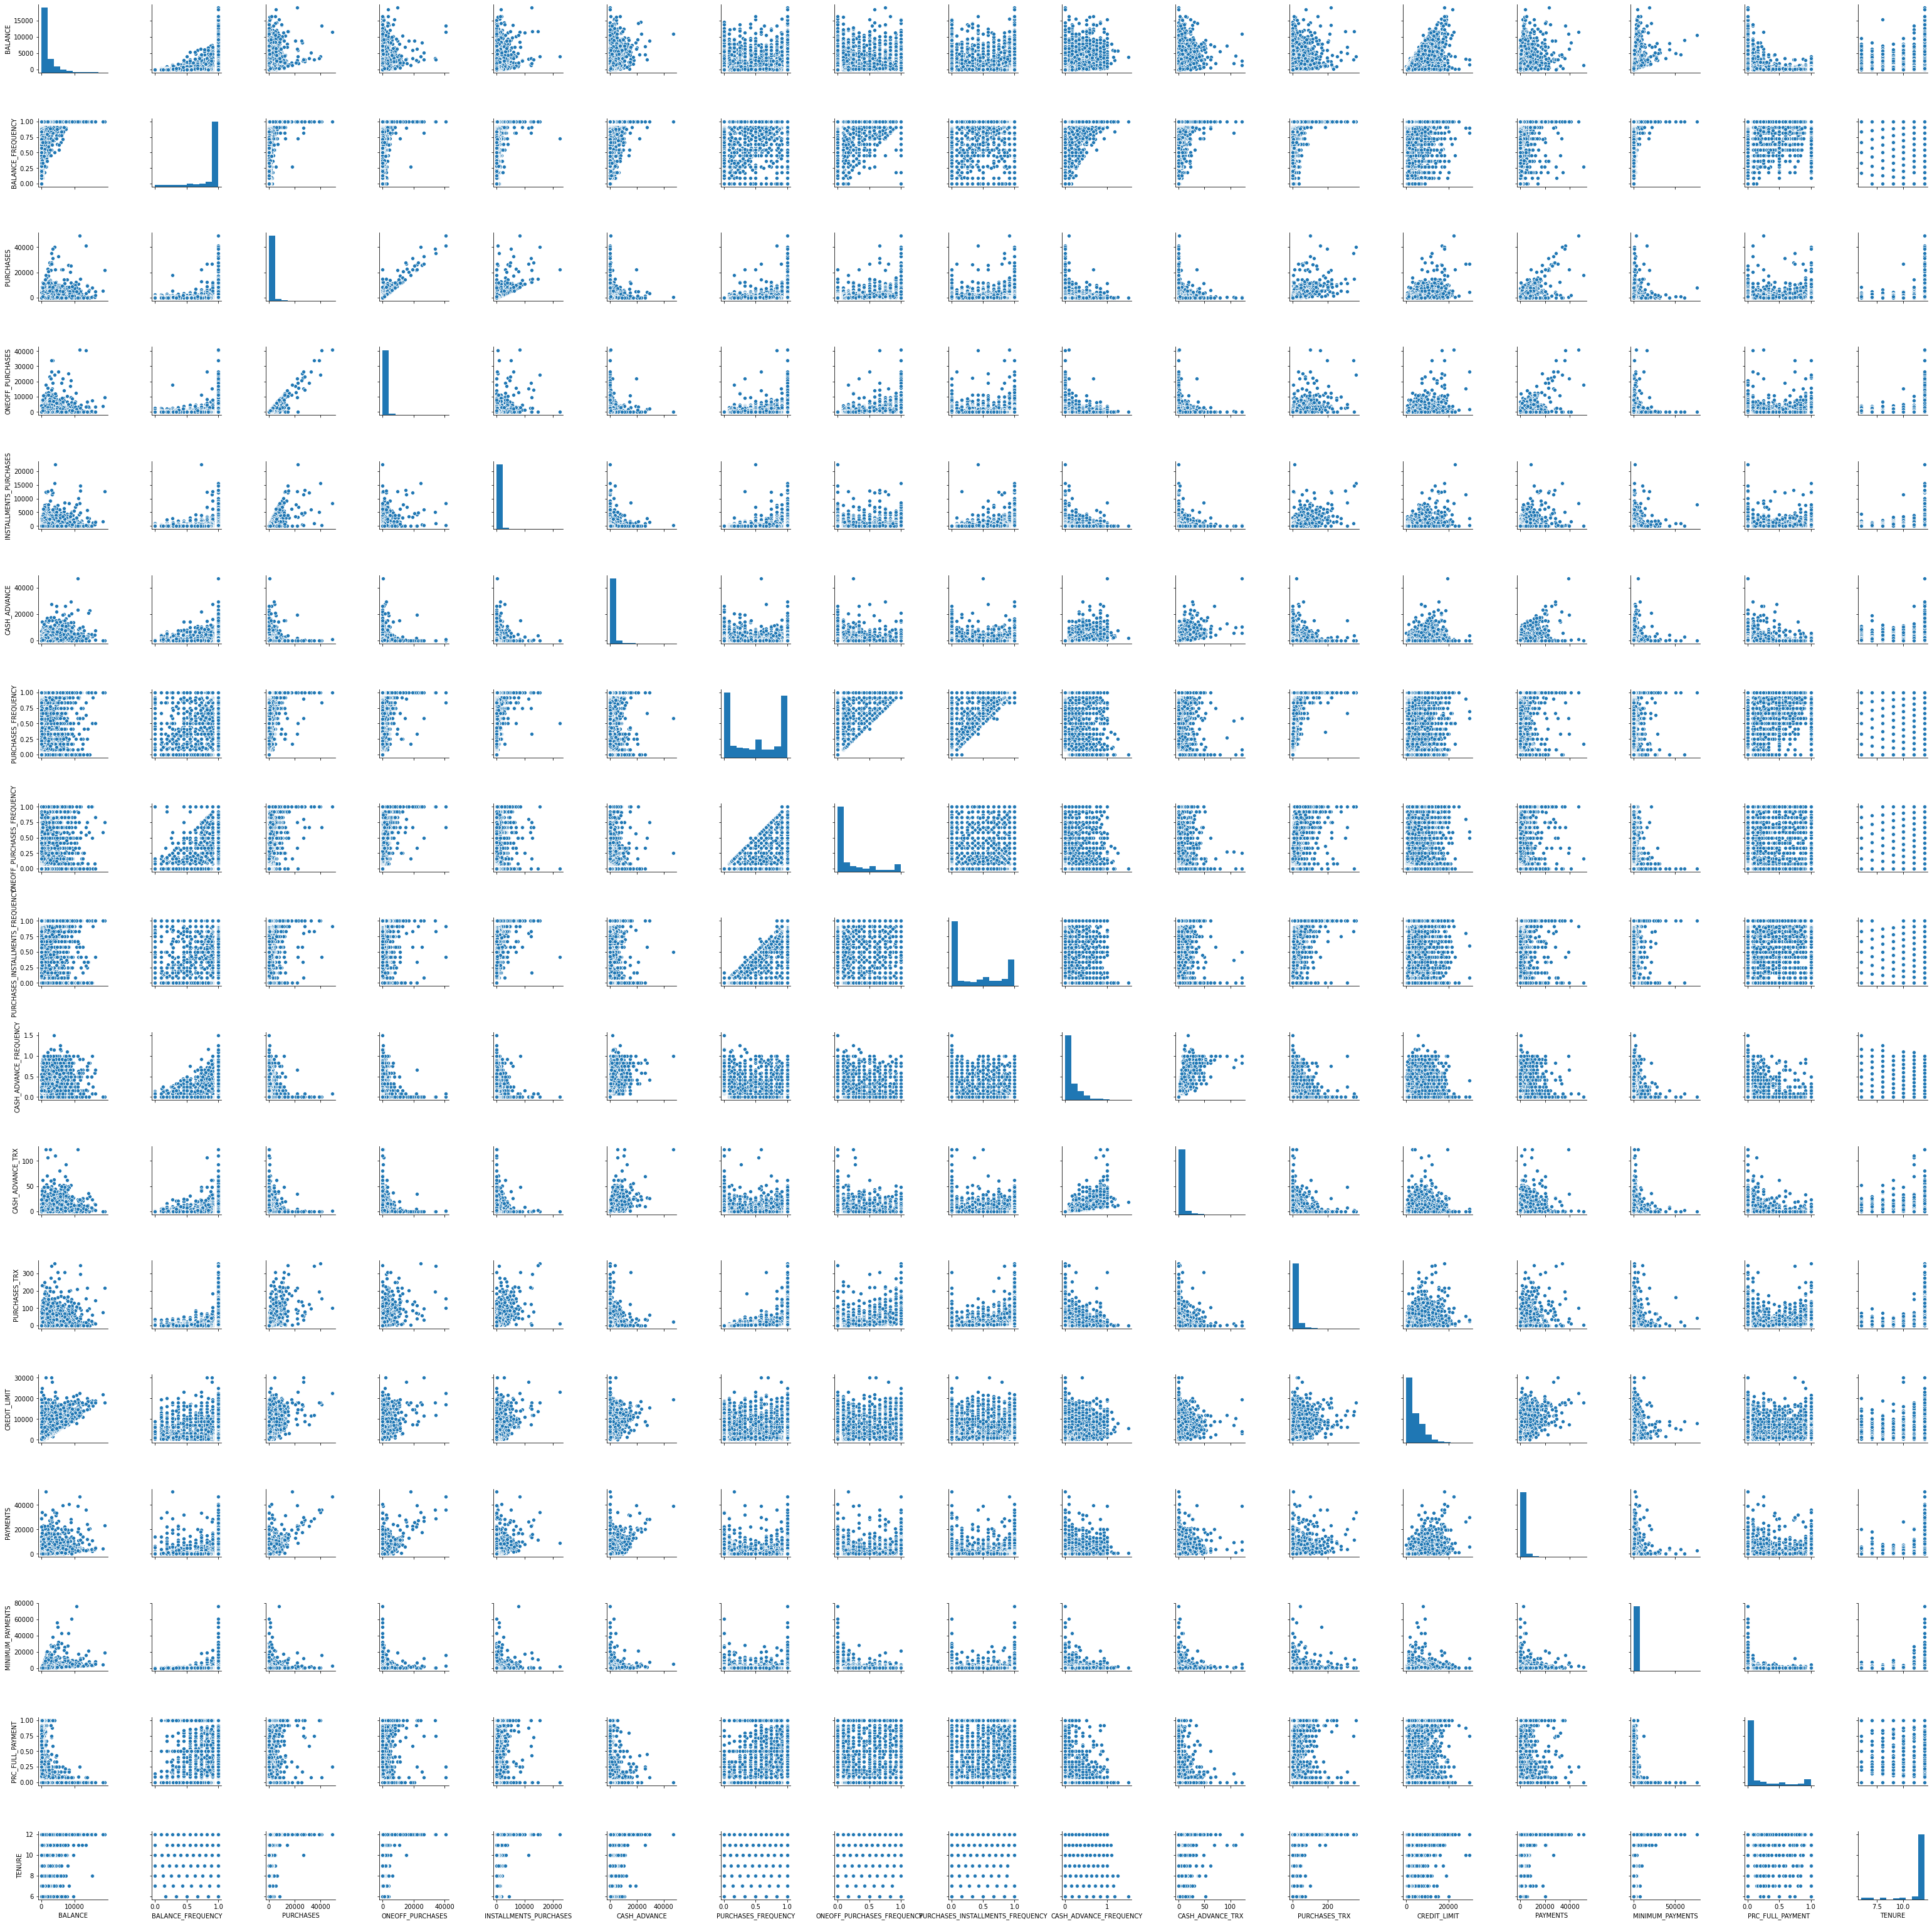

In [40]:
# Look for correlations...plots everithing vs everithings
#sns.set_theme(style="ticks")
#fig=plt.figure(figsize=(15, 15))
sns.pairplot(customers_df);

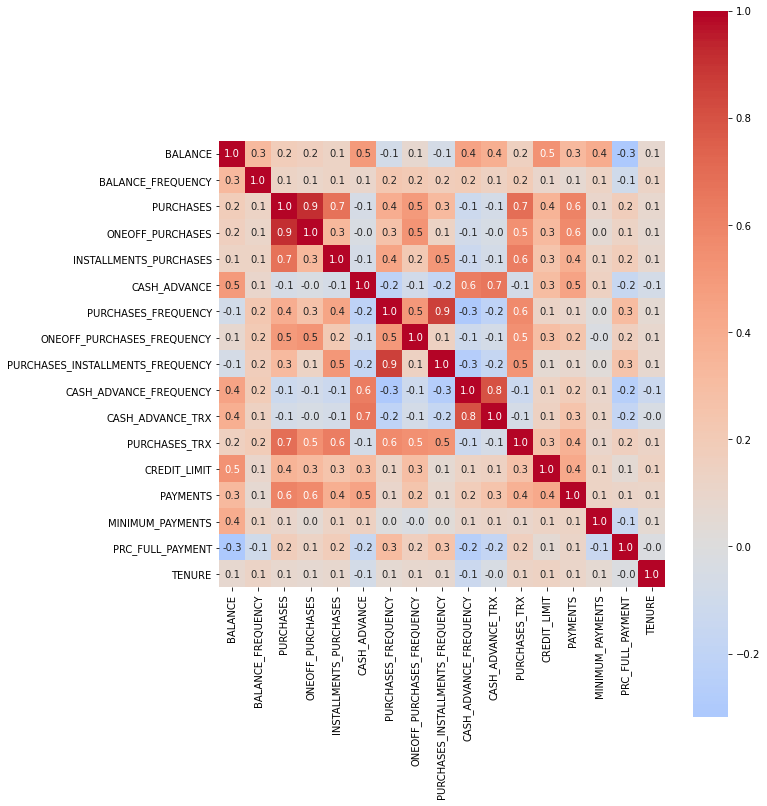

In [25]:
# Now we can check the correlation using .corr()
fig=plt.figure(figsize=(10, 13))
sns.heatmap(customers_df.corr(), cmap='coolwarm', annot=True, square=True, center=0.0, fmt='.1f');

So, it seems there are lot of strong correlations: 
- balance with cash_advance and credit_limit;
- purchases with one-off prurchases, installment purchases, purchases_trx;
- purchases frequency with purchases_installement_frequancy;
- cash_advance_frequency with cash_advance_trx;

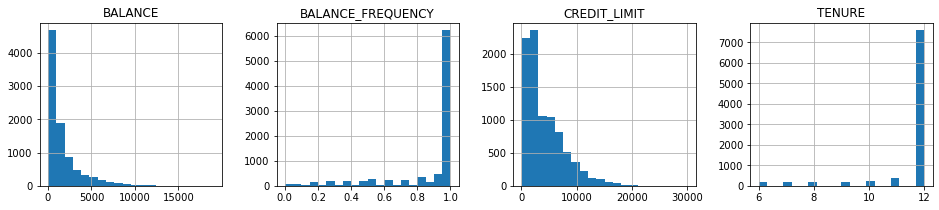

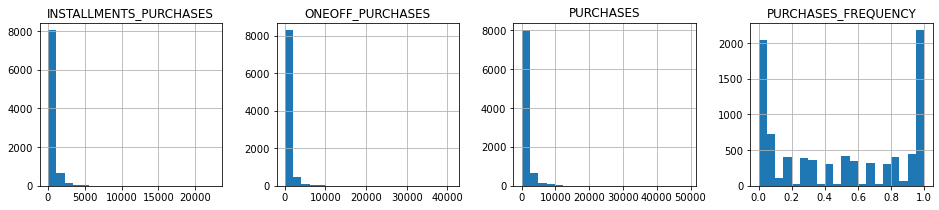

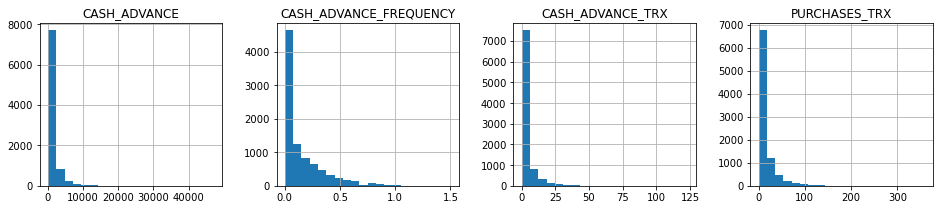

In [43]:
# Check some distributions
features = ['BALANCE', 'BALANCE_FREQUENCY', 'TENURE', 'CREDIT_LIMIT']
customers_df.hist(column=features, bins=20, layout=(1,4), figsize=(16,3));

features = ['PURCHASES', 'ONEOFF_PURCHASES', 'INSTALLMENTS_PURCHASES', 'PURCHASES_FREQUENCY']
customers_df.hist(column=features, bins=20, layout=(1,4), figsize=(16,3));

features = ['CASH_ADVANCE', 'CASH_ADVANCE_FREQUENCY', 'CASH_ADVANCE_TRX', 'PURCHASES_TRX']
customers_df.hist(column=features, bins=20, layout=(1,4), figsize=(16,3));

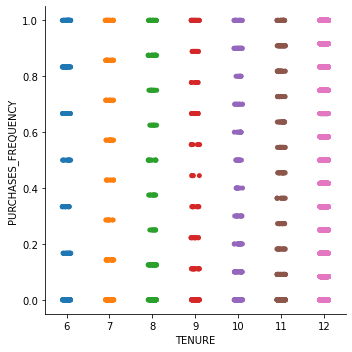

In [17]:
# Check the purchases_frequency versus the tenure
sns.catplot(x='TENURE', y='PURCHASES_FREQUENCY', data=customers_df)

I would like to check what kind of purchases are most common for users, if frequents but small amount or big amount but rare...

## Data Clustering

## Data scaling
First of all we need to rescale, they present a really wide interval, the features otherwise any algo could be wrong. I can use RobustScaler because there are lot of outliers into the data.

In [46]:
scaler = RobustScaler
scaled_customers_data = scaler.fit_transform(customers_df)

## Get rid of correlated variables
A usual way to eliminate correlation is to use PCA